In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

file_path = 'C:/Users/RaymondCarpenter/Documents/GitHub/14thstreetanalytics/nfl-draft/rb_sheet.csv'
data = pd.read_csv(file_path)

numeric_columns = data.select_dtypes(include='number').columns
percentiles = data[numeric_columns].apply(lambda x: x.rank(pct=True))
data_with_percentiles = pd.concat([data, percentiles.add_suffix('_percentile')], axis=1)

normalized_fields = ['rush_attempts', 'rush_yards', 'rush_td', 'receptions', 'rec_yards', 'rec_td']
for field in normalized_fields:
    data_with_percentiles[field + '_per_game'] = data_with_percentiles[field] / data_with_percentiles['games_played']

normalized_features = ['height_in', 'weight_lbs', '40_yard_dash'] + [f + '_per_game' for f in normalized_fields]
players_2024 = data_with_percentiles[data_with_percentiles['draft_class'] == 2024].dropna(subset=normalized_features)
players_not_2024 = data_with_percentiles[data_with_percentiles['draft_class'] != 2024].dropna(subset=normalized_features)

scaler = StandardScaler()
features_2024_normalized = scaler.fit_transform(players_2024[normalized_features])
features_not_2024_normalized = scaler.transform(players_not_2024[normalized_features])

cosine_similarities_normalized = cosine_similarity(features_2024_normalized, features_not_2024_normalized)
closest_indices_cosine_normalized = cosine_similarities_normalized.argmax(axis=1)
closest_players_cosine_normalized = players_not_2024.iloc[closest_indices_cosine_normalized]['name'].values

similar_players_mapping_cosine_normalized = pd.DataFrame({
    '2024_Player': players_2024['name'].values,
    'Most_Similar_Non_2024_Cosine_Normalized': closest_players_cosine_normalized
})

player_name = input("Enter a 2024 player name to find the most similar player from non-2024 classes: ")
player_info = similar_players_mapping_cosine_normalized[similar_players_mapping_cosine_normalized['2024_Player'].str.contains(player_name, case=False)]
if player_info.empty:
    print("Player not found or no similar player available.")
else:
    print(player_info)


     2024_Player Most_Similar_Non_2024_Cosine_Normalized
7  Braelon Allen                             Jeremy Hill


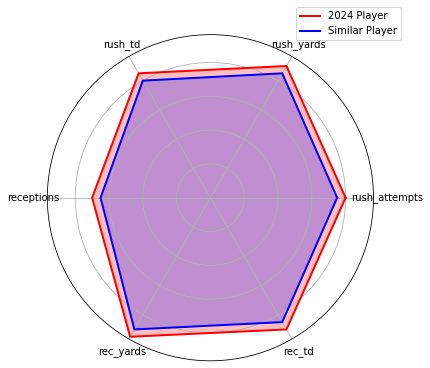

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example percentile data for two players
metrics = ['rush_attempts', 'rush_yards', 'rush_td', 'receptions', 'rec_yards', 'rec_td']
player_2024_percentiles = [0.8, 0.9, 0.85, 0.7, 0.95, 0.9]  # Example data
similar_player_percentiles = [0.75, 0.85, 0.8, 0.65, 0.9, 0.85]  # Example data

# Combine data into a DataFrame for easier handling
df_percentiles = pd.DataFrame({
    'Metric': metrics,
    '2024_Player': player_2024_percentiles,
    'Similar_Player': similar_player_percentiles
})

# Number of variables we're plotting.
num_vars = len(df_percentiles['Metric'])

# Split the circle into even parts and save angles so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The radar chart needs to be a closed circle, so we need to "complete the loop"
# and append the start value to the end.
player_2024_percentiles += player_2024_percentiles[:1]
similar_player_percentiles += similar_player_percentiles[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, player_2024_percentiles, color='red', alpha=0.25)
ax.plot(angles, player_2024_percentiles, color='red', linewidth=2, label='2024 Player')
ax.fill(angles, similar_player_percentiles, color='blue', alpha=0.25)
ax.plot(angles, similar_player_percentiles, color='blue', linewidth=2, label='Similar Player')

# Labels for each axis
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(df_percentiles['Metric'])

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
data = pd.read_csv('C:/Users/RaymondCarpenter/Documents/GitHub/14thstreetanalytics/nfl-draft/rb_sheet.csv')

# Fields to normalize by 'games_played' and fields used directly
fields_to_normalize = [
'rush_attempts','rush_yards','rush_avg','rush_td','receptions','rec_yards','rec_avg','rec_td'
]
fields_not_normalized = [
'height_in','weight_lbs','hand_size_in','arm_length_in','wonderlic','40_yard_dash','Bench press','vertical_in','broad_jump_in','shuttle','3_cone','60Yd Shuttle'
]

# Ensure all columns are numeric or convert them as needed
for field in fields_to_normalize + fields_not_normalized + ['games_played', 'years_played']:
    data[field] = pd.to_numeric(data[field], errors='coerce')

def normalize_fields(df, fields_to_normalize, norm_by='games_played'):
    for field in fields_to_normalize:
        df[field + ' Per Game'] = df[field] / df[norm_by]
    return df

# Apply normalization
data = normalize_fields(data, fields_to_normalize)

# Prepare the features list for similarity comparison
features_normalized = [f'{field} Per Game' for field in fields_to_normalize]
features = features_normalized + fields_not_normalized + ['games_played', 'years_played']

# Add cumulative stats to the features list for comparison
features += fields_to_normalize

# Fill missing values with the mean of each column
data_filled = data[features].fillna(data[features].mean(), inplace=False)

# Separate datasets
data_2024 = data[data['draft_class'] == 2024]
data_not_2024 = data[data['draft_class'] != 2024]

# Normalize the feature values using StandardScaler
scaler = StandardScaler()
data_2024_scaled = scaler.fit_transform(data_filled.loc[data_2024.index])
data_not_2024_scaled = scaler.transform(data_filled.loc[data_not_2024.index])

# Calculate cosine similarity
similarity = cosine_similarity(data_2024_scaled, data_not_2024_scaled)

# Input for a specific 2024 player's name
player_name = input("Enter the name of the 2024 player to compare: ")

try:
    player_index = data_2024[data_2024['name'].str.lower() == player_name.lower()].index[0]
    similarity_scores = similarity[player_index - data_2024.index[0]]
    most_similar_index = similarity_scores.argmax()
    most_similar_player_name = data_not_2024.iloc[most_similar_index]['name']
    percentage_similarity = (similarity_scores[most_similar_index] + 1) / 2 * 100

    print(f"\nThe most similar player to {player_name} is {most_similar_player_name} with {percentage_similarity:.2f}% similarity.\n")

    # Gather stats for comparison
    player_stats = data_filled.loc[data_2024.index][features].iloc[player_index - data_2024.index[0]]
    similar_player_stats = data_filled.loc[data_not_2024.index][features].iloc[most_similar_index]

    comparison_df = pd.DataFrame({
        player_name: player_stats.values,
        most_similar_player_name: similar_player_stats.values
    }, index=features)
    
    print(comparison_df)
except IndexError:
    print("Player not found in the 2024 draft class. Please check the name and try again.")


KeyError: "None of [Index(['rush_attempts Per Game_percentile', 'rush_yards Per Game_percentile',\n       'rush_avg Per Game_percentile', 'rush_td Per Game_percentile',\n       'receptions Per Game_percentile', 'rec_yards Per Game_percentile',\n       'rec_avg Per Game_percentile', 'rec_td Per Game_percentile',\n       'height_in_percentile', 'weight_lbs_percentile',\n       'hand_size_in_percentile', 'arm_length_in_percentile',\n       '40_yard_dash_percentile', 'vertical_in_percentile',\n       'broad_jump_in_percentile', 'games_played_percentile',\n       'years_played_percentile', 'rush_attempts_percentile',\n       'rush_yards_percentile', 'rush_avg_percentile', 'rush_td_percentile',\n       'receptions_percentile', 'rec_yards_percentile', 'rec_avg_percentile',\n       'rec_td_percentile'],\n      dtype='object')] are in the [index]"

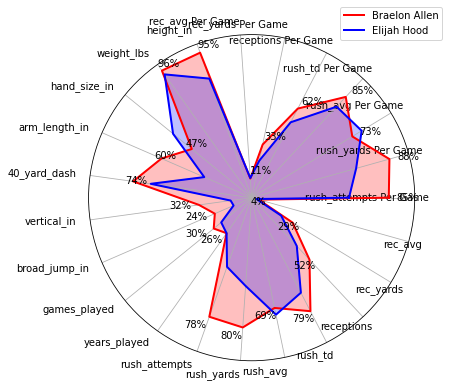

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from math import pi

# Calculate percentiles for the dataset
def calculate_percentiles(df, features):
    for feature in features:
        percentile_col_name = f'{feature}_percentile'
        df[percentile_col_name] = df[feature].rank(pct=True)
    return df

data_filled = calculate_percentiles(data_filled, features)

# Separate datasets for 2024 and not 2024
data_2024 = data[data['draft_class'] == 2024]
data_not_2024 = data[data['draft_class'] != 2024]

# Normalize the feature values using StandardScaler
scaler = StandardScaler()
features_to_scale = features_normalized + fields_not_normalized + ['games_played', 'years_played'] + fields_to_normalize
data_filled_scaled = scaler.fit_transform(data_filled[features_to_scale])
data_filled[features_to_scale] = data_filled_scaled

data_2024_scaled = data_filled.loc[data_2024.index]
data_not_2024_scaled = data_filled.loc[data_not_2024.index]

# Calculate cosine similarity
similarity = cosine_similarity(data_2024_scaled[features_to_scale], data_not_2024_scaled[features_to_scale])

player_name = input("Enter the name of the 2024 player to compare: ")

try:
    player_index = data_2024[data_2024['name'].str.lower() == player_name.lower()].index[0]
    similarity_scores = similarity[player_index - data_2024.index[0]]
    most_similar_index = similarity_scores.argmax()
    most_similar_player_name = data_not_2024.iloc[most_similar_index]['name']
    
    # Determine which features to include by excluding those with NaN or 0 for the selected player
    player_data_for_filtering = data.loc[player_index, features]
    features_for_radar = player_data_for_filtering[player_data_for_filtering.notna() & (player_data_for_filtering != 0)].index.tolist()

    # Convert to percentile names for those filtered features
    percentile_features = [f'{feature}_percentile' for feature in features_for_radar if feature in data_filled.columns]
    
    player_percentiles = data_filled.loc[player_index, percentile_features]
    similar_player_percentiles = data_filled.loc[data_not_2024.index[most_similar_index], percentile_features]

    # Continue with the radar chart creation as before, but only for the filtered features
    labels = np.array(features_for_radar)
    num_vars = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop
    
    player_stats = player_percentiles.tolist() + player_percentiles.tolist()[:1]
    similar_player_stats = similar_player_percentiles.tolist() + similar_player_percentiles.tolist()[:1]
    
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, player_stats, color='red', alpha=0.25)
    ax.fill(angles, similar_player_stats, color='blue', alpha=0.25)
    ax.plot(angles, player_stats, color='red', linewidth=2, label=player_name)
    ax.plot(angles, similar_player_stats, color='blue', linewidth=2, label=most_similar_player_name)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks([])  # Removes radial gridlines

    # Add text labels for the percentiles, adjusting for the removed categories
    for label, angle, stat in zip(labels, angles[:-1], player_stats[:-1]):
        ha = 'right' if angle > pi else 'left' if angle < pi else 'center'
        ax.text(angle, stat + 0.05, f"{int(stat*100)}%", size=10, horizontalalignment=ha, verticalalignment="center")

    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

except IndexError:
    print("Player not found in the 2024 draft class. Please check the name and try again.")

